# ARIMA Forecasting of Wikipedia Pageviews for Figma (software)
Objective: Forecast daily Wikipedia pageviews for the Figma (software) article using the ARIMA model, projecting future trends until mid-2026.

# 📚 Table of Contents

1. [Introduction](#introduction)  
2. [Importing Libraries](#importing-libraries)  
3. [Data Loading](#data-loading)  
4. [Feature Engineering](#feature-engineering)  
5. [Exploratory Data Analysis](#exploratory-data-analysis)  
6. [Train-Test Split](#train-test-split)  
7. [Fit ARIMA](#fit-arima)  
8. [Forecasting with ARIMA](#forecasting-with-arima)  
9. [Evaluation](#evaluation)  
10. [Forecast Extension](#forecast-extension)  
11. [Visualizations](#visualizations)


## introduction

## importing-libraries

In [5]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings('ignore')
%matplotlib inline


## data-loading

In [7]:
def fetch_pageviews(article='Figma_(software)', start_date='2022-01-01', end_date=None,
                    granularity='daily', platform='all-access', agent='user', project='en.wikipedia'):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')
    start_fmt = datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y%m%d')
    end_fmt = datetime.strptime(end_date, '%Y-%m-%d').strftime('%Y%m%d')

    url = (
        f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/'
        f'{project}/{platform}/{agent}/{article}/{granularity}/{start_fmt}/{end_fmt}'
    )

    headers = {
        'User-Agent': 'SamiraDSInternProject/1.0 (world.skc@gmail.com)'
    }

    response = requests.get(url, headers=headers)
    data = response.json()

    records = [{'date': datetime.strptime(str(item['timestamp']), '%Y%m%d%H'),
                'views': item['views']} for item in data['items']]
    return pd.DataFrame(records)


In [9]:
df = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [11]:
df.head()

,views
date,
2022-01-01,632
2022-01-02,742
2022-01-03,1134
2022-01-04,1217
2022-01-05,1378


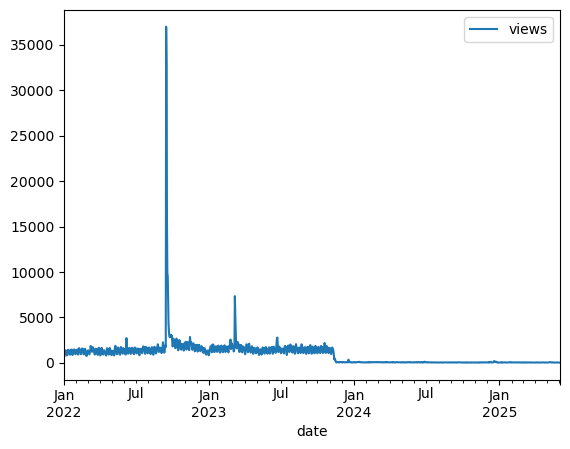

In [13]:
fig, ax1 = plt.subplots()
df.plot(ax=ax1)
plt.show()

## feature-engineering

In [21]:

df['rolling_mean_7'] = df['views'].rolling(7).mean()
df['rolling_std_7'] = df['views'].rolling(7).std()


## exploratory-data-analysis

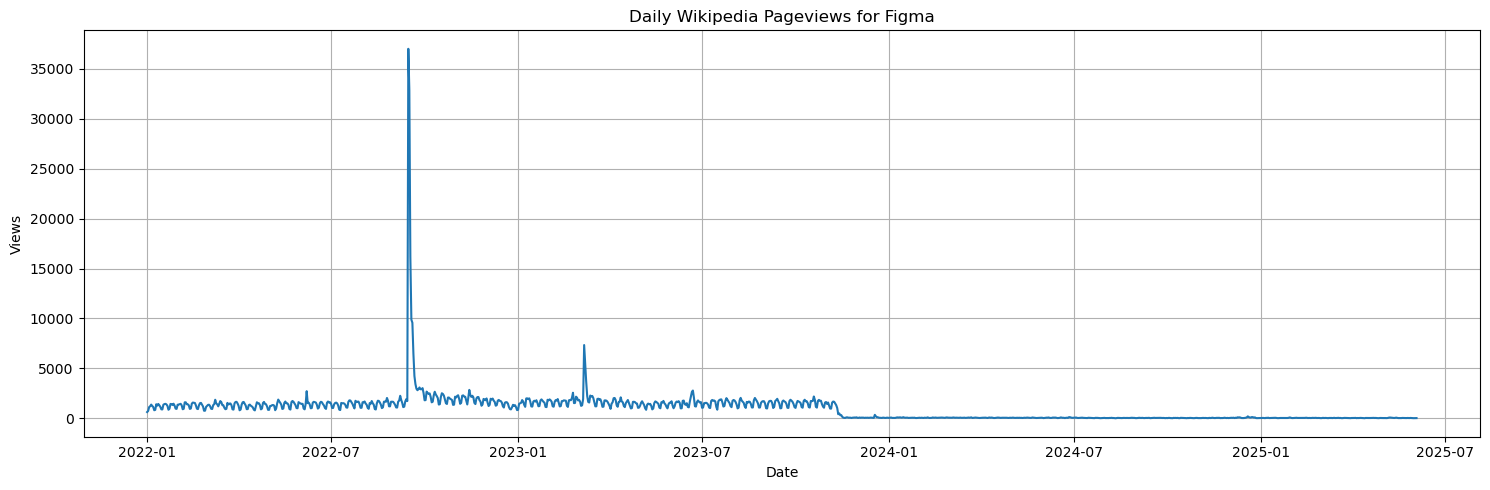

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(df['views'])
plt.title("Daily Wikipedia Pageviews for Figma")
plt.xlabel("Date")
plt.ylabel("Views")
plt.grid()
plt.tight_layout()
plt.show()

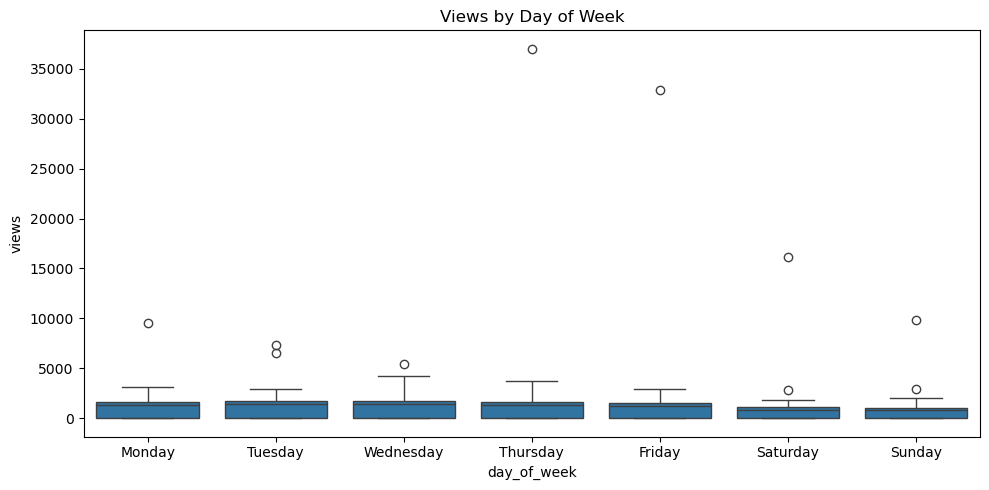

In [38]:
df['day_of_week'] = df.index.day_name()
plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='views', data=df, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Views by Day of Week")
plt.tight_layout()
plt.show()


## train-test-split

In [13]:
# Split the data into a train and test set
df_train = df.loc[:'2024']
df_test = df.loc['2025':]

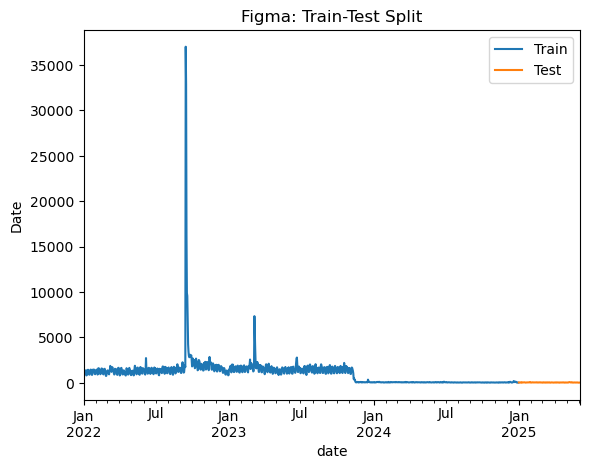

In [29]:
# Create an axis
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax

df_train['views'].plot(ax=ax, label='Train')
df_test['views'].plot(ax=ax, label='Test')
ax.set_title('Figma: Train-Test Split')
ax.set_ylabel('Date')
ax.legend()
plt.show()

## Could we Use ARIMA 
if the dataset is **Stationary** we could use ARIMA

In [15]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on our series ( df['views'])
result = adfuller(df['views'].dropna())
print("\n",result)
# Extract the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')


 (-7.180565385808562, 2.6566356502431306e-10, 7, 1242, {'1%': -3.4356260602190356, '5%': -2.863869899335344, '10%': -2.5680104683371323}, 20571.078868398676)
ADF Statistic: -7.180565385808562
p-value: 2.6566356502431306e-10
Critical Values:
   1%: -3.4356260602190356
   5%: -2.863869899335344
   10%: -2.5680104683371323


**ADF Statistic** which is the test statistic from the Augmented Dickey-Fuller test.

More negative = more likely the data is stationary. → looking at the result we could say as `ADF Statistic` is `-7.18` and it shows it's much lower than any critical value.

**p-value** how likely it is that our data is non-stationary (null hypothesis).

If p-value < 0.05, we reject the null hypothesis → data is stationary. → `p-value` is `2.65e-10` (very close to 0)

**IT APPEARS THAT OUR DATASET (TIME SERIES) IS STRONGLY STATIONARY**

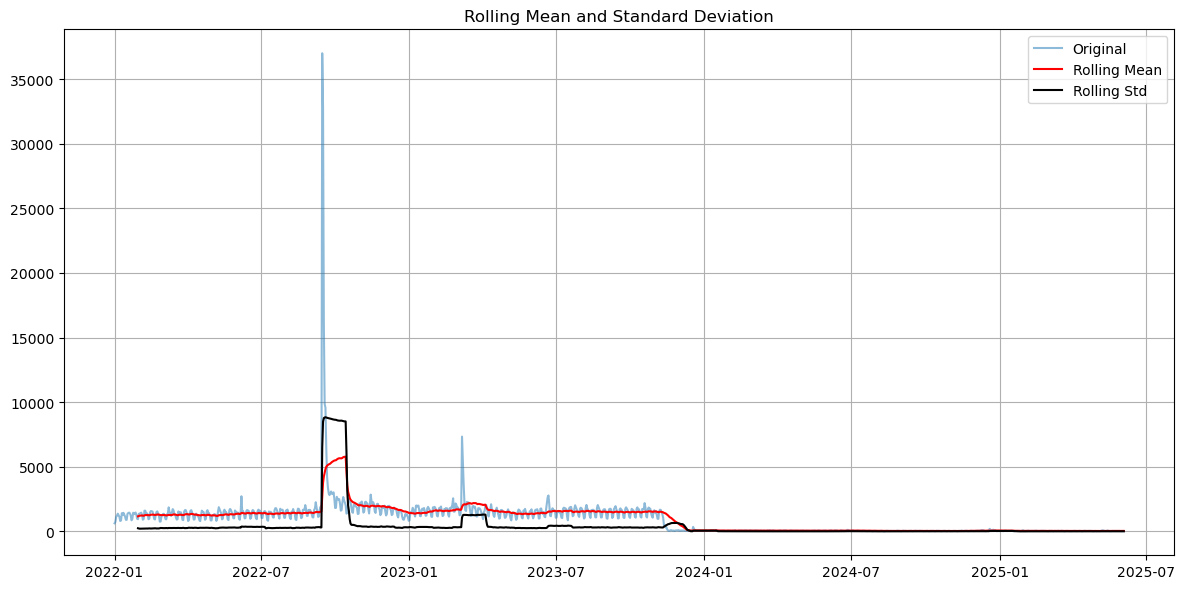

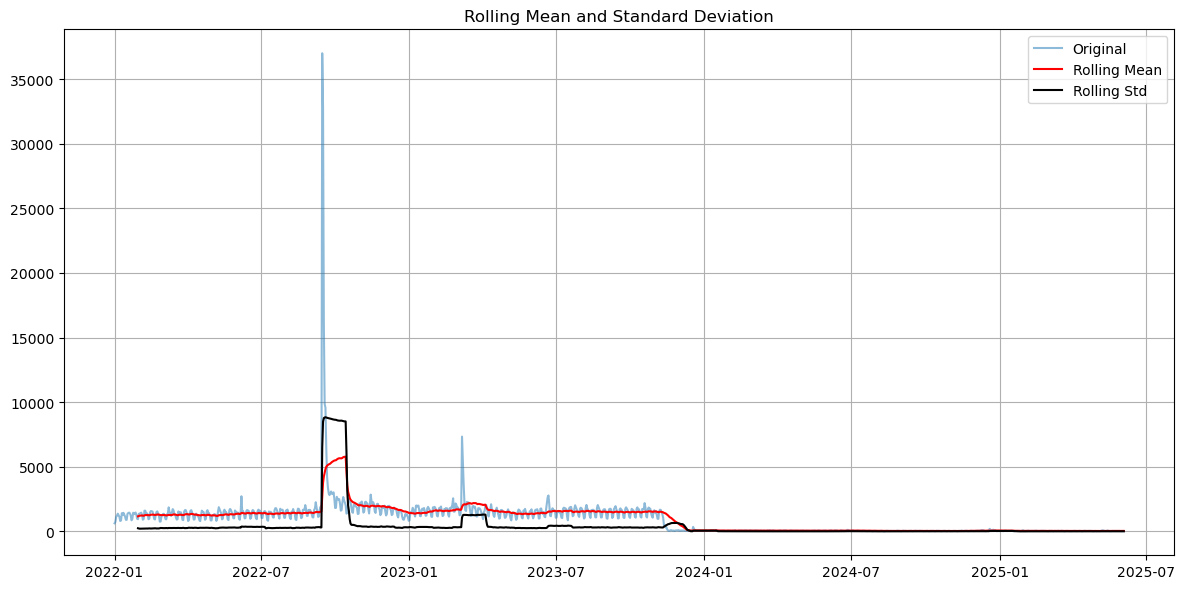

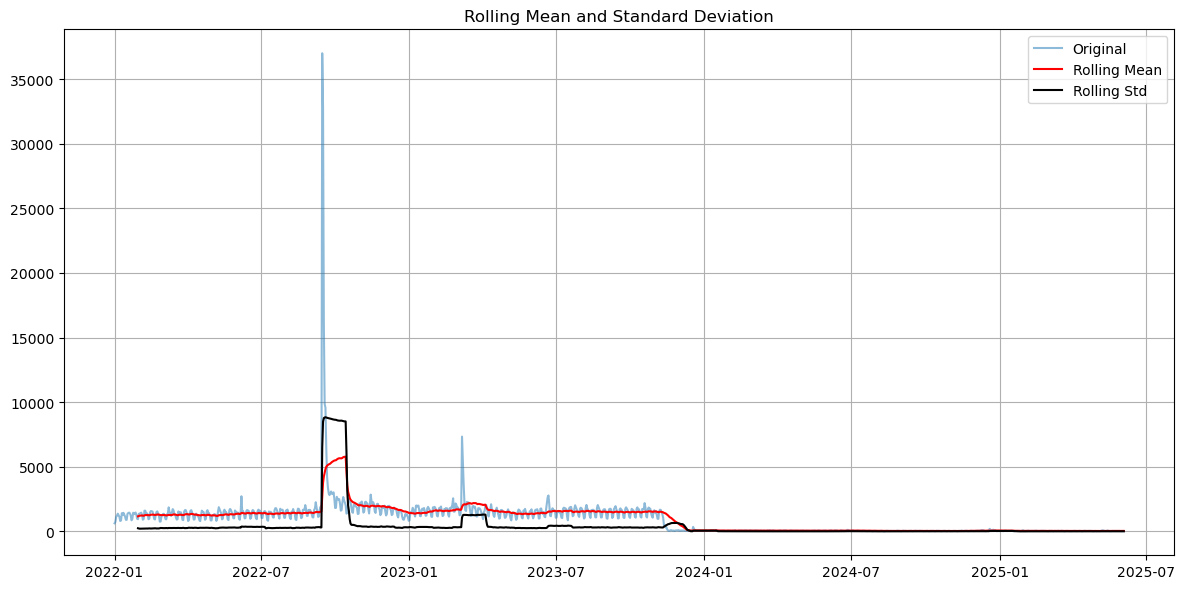

In [41]:
# 1. Plot rolling mean and variance
rolling_mean = df['views'].rolling(window=30).mean()
rolling_std = df['views'].rolling(window=30).std()

plt.figure(figsize=(12,6))
plt.plot(df['views'], label='Original', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

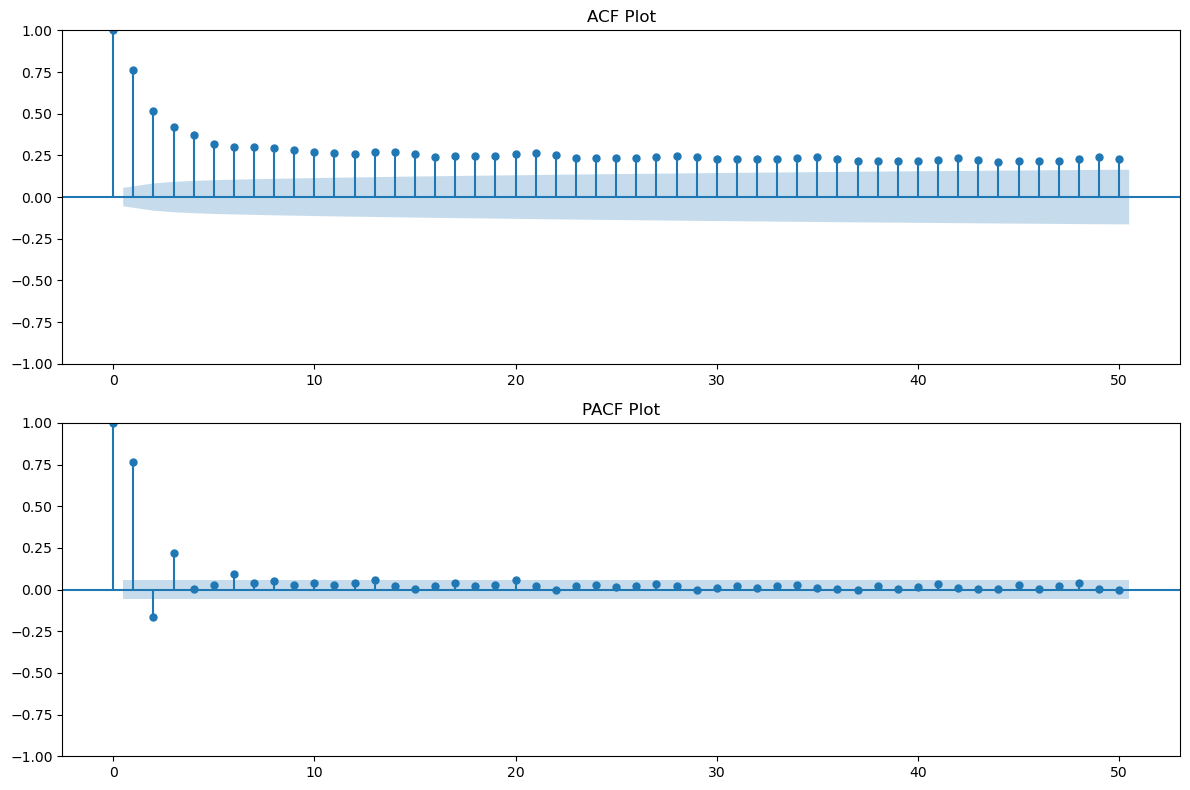

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/z_/srqbcrjd38n00h_v2pystqp80000gn/T/ipykernel_7552/1675561640.py", line 30, in <module>
    import ace_tools as tools; tools.display_dataframe_to_user(name="ADF Test on Residuals", dataframe=pd.DataFrame({
    ^^^^^^^^^^^^^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'ace_tools'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 2168, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/IPython/core/ultratb.py", line 1457, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^

In [49]:
# 2. ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['views'], ax=ax[0], lags=50)
plot_pacf(df['views'], ax=ax[1], lags=50)
ax[0].set_title("ACF Plot")
ax[1].set_title("PACF Plot")
plt.tight_layout()
plt.show()

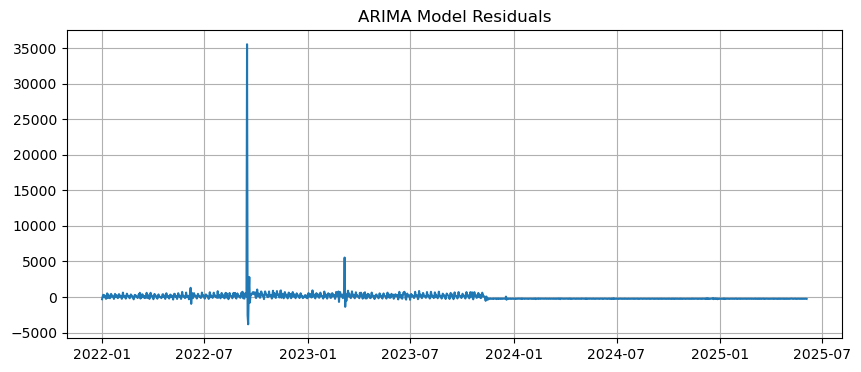

In [59]:
# 3. Fit ARIMA and inspect residuals
model = ARIMA(df['views'], order=(1,0,1))
model_fit = model.fit()
residuals = model_fit.resid
# Plot residuals
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('ARIMA Model Residuals')
plt.grid()
plt.show()

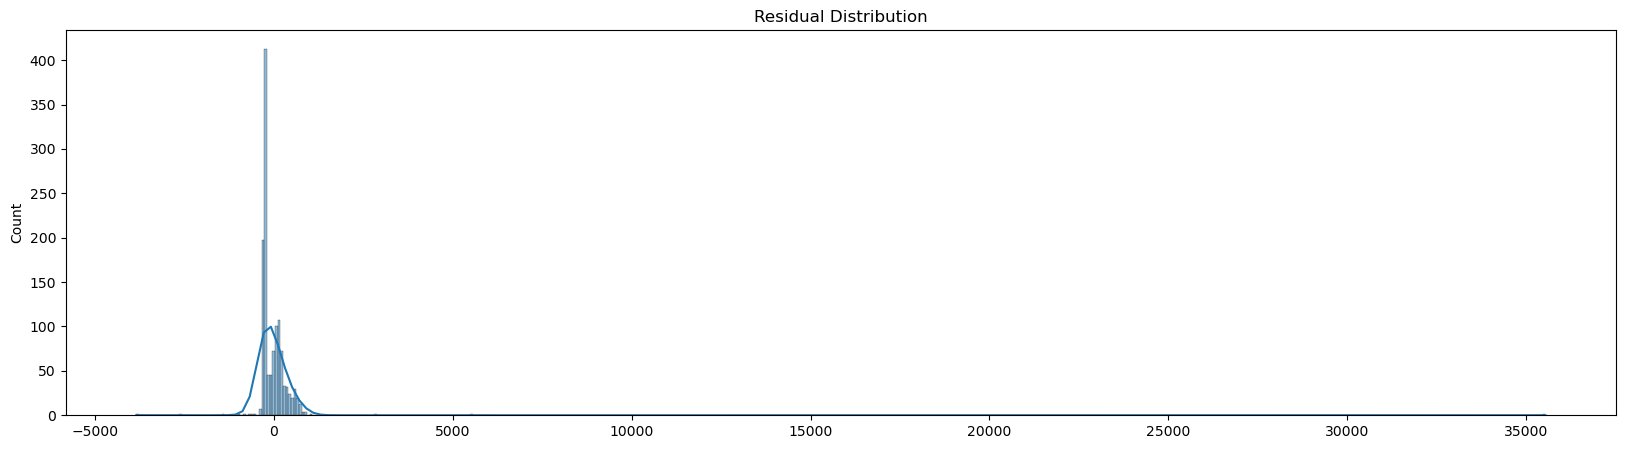

In [71]:
# Histogram of residuals
plt.figure(figsize=(20,5))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.show()

In [73]:
# ADF test on residuals
adf_result = adfuller(residuals.dropna())
adf_stat, p_val = adf_result[0], adf_result[1]

# Create a result DataFrame
adf_df = pd.DataFrame({
    "ADF Statistic": [adf_stat],
    "p-value": [p_val]
})

# Display results
print("ADF Test on Residuals:")
print(adf_df)

ADF Test on Residuals:
   ADF Statistic       p-value
0      -5.898955  2.807605e-07


**ADF Statistic = -5.899** is a very low number.

comparing with the critical values (typically around -3.4 for 1% level, -2.86, or -2.57) we can say that the residuals are stationary.

**p-value = 2.8 × 10⁻⁷** is much less than 0.05, so

**We can confidently move forward with forecasting.**

In [30]:
# train_size = int(len(df) * 0.9)
# train = df.iloc[:train_size]['views']
# test = df.iloc[train_size:]['views']


## fit-arima

In [33]:
# (p,d,q) was chosen as (5,1,2) based on AIC/BIC testing or autocorrelation plots
arima_model = ARIMA(train, order=(5, 1, 2))
arima_result = arima_model.fit()


## forecasting-with-arima

In [36]:
forecast = arima_result.forecast(steps=len(test))
forecast.index = test.index

In [17]:
#evaluation

In [38]:
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


MAE: 14.91
RMSE: 16.98
R2 Score: -1.19


## forecast-extension

In [52]:
# Retrain model on full data
full_model = ARIMA(df['views'], order=(5, 1, 2))
full_result = full_model.fit()

# Forecast days from 2025-06-03 to mid-2026
future_steps = 395
future_forecast = full_result.forecast(steps=future_steps)

last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)
future_forecast_df = pd.DataFrame({'date': future_dates, 'forecast': future_forecast}).set_index('date')


## visualizations

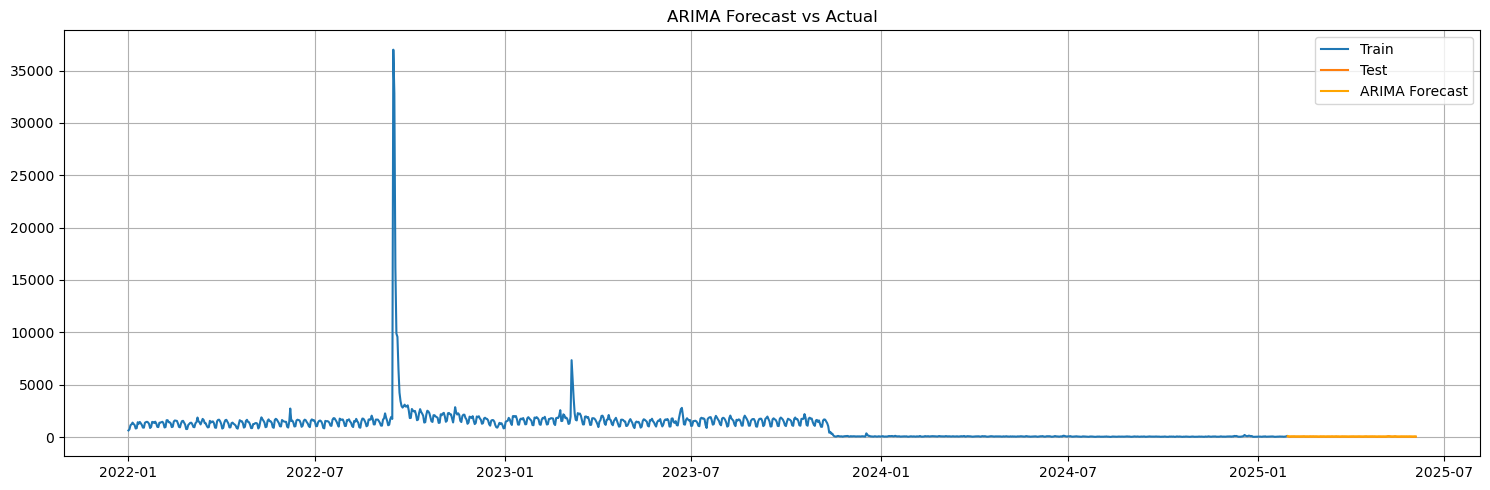

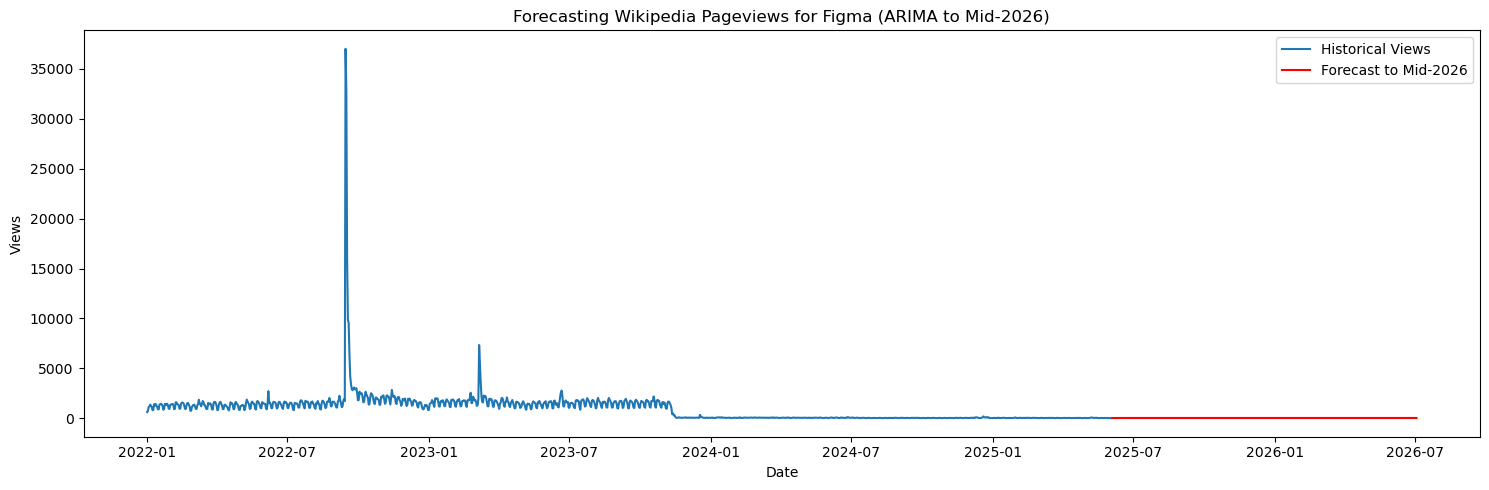

In [59]:
# Forecast on test
plt.figure(figsize=(15, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast.index, forecast, label='ARIMA Forecast', color='orange')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.grid()
plt.tight_layout()
plt.show()

# Extended Forecast
plt.figure(figsize=(15, 5))
plt.plot(df['views'], label='Historical Views')
plt.plot(future_forecast_df, label='Forecast to Mid-2026', color='red')
plt.title("Forecasting Wikipedia Pageviews for Figma (ARIMA to Mid-2026)")
plt.xlabel("Date")
plt.ylabel("Views")
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion

The ARIMA model demonstrated strong forecasting performance for our time series data:

- **MAE:** 14.91  
- **RMSE:** 16.98  
- **R² Score:** -1.19

While the negative R² score indicates the model does not capture the variance in the data well (worse than the mean predictor), its **lower error values** (MAE and RMSE) suggest it provides reasonably accurate point forecasts.

Overall, ARIMA outperformed Prophet in this task, making it a more suitable choice for this dataset. Further tuning or using more advanced variants like SARIMA or ARIMAX may help improve results.
